In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

data = pd.read_csv('/content/gdrive/MyDrive/healthcare-dataset-stroke-data.csv')

data.drop(columns=['id'], inplace=True)


data['bmi'].fillna(data['bmi'].median(), inplace=True)


label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


X = data.drop(columns=['stroke'])
y = data['stroke']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    matrix = confusion_matrix(y_test, y_pred)
    return report, matrix


results_nb = {}
models_nb = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

gnb = GaussianNB()
gnb.fit(X_train, y_train)
report_gnb, matrix_gnb = evaluate_model(gnb, X_test, y_test)
results_nb["GaussianNB"] = {"classification_report": report_gnb, "confusion_matrix": matrix_gnb}


X_non_negative = scaler.inverse_transform(X_train)  # Inverse transform to original scale
X_test_non_negative = scaler.inverse_transform(X_test)
X_non_negative = np.maximum(0, X_non_negative)
X_test_non_negative = np.maximum(0, X_test_non_negative)


for name in ["MultinomialNB", "BernoulliNB"]:
    model = models_nb[name]
    model.fit(X_non_negative, y_train)
    report, matrix = evaluate_model(model, X_test_non_negative, y_test)
    results_nb[name] = {"classification_report": report, "confusion_matrix": matrix}


results_svm = {}
kernels = ['linear', 'poly', 'rbf']

for kernel in kernels:
    svm_model = SVC(kernel=kernel, probability=True, random_state=42)
    svm_model.fit(X_train, y_train)
    report, matrix = evaluate_model(svm_model, X_test, y_test)
    results_svm[kernel] = {"classification_report": report, "confusion_matrix": matrix}


print("Naive Bayes Results:")
for model_name, result in results_nb.items():
    print(f"\nModel: {model_name}")
    print("Classification Report:")
    print(pd.DataFrame(result["classification_report"]))
    print("Confusion Matrix:")
    print(result["confusion_matrix"])


print("\nSVM Results:")
for kernel, result in results_svm.items():
    print(f"\nKernel: {kernel}")
    print("Classification Report:")
    print(pd.DataFrame(result["classification_report"]))
    print("Confusion Matrix:")
    print(result["confusion_matrix"])


<ipython-input-2-2732d830db73>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565

Naive Bayes Results:

Model: GaussianNB
Classification Report:
                     0          1  accuracy    macro avg  weighted avg
precision     0.965595   0.147959  0.861057     0.556777      0.925593
recall        0.885460   0.386667  0.861057     0.636063      0.861057
f1-score      0.923792   0.214022  0.861057     0.568907      0.889068
support    1458.000000  75.000000  0.861057  1533.000000   1533.000000
Confusion Matrix:
[[1291  167]
 [  46   29]]

Model: MultinomialNB
Classification Report:
                     0          1  accuracy    macro avg  weighted avg
precision     0.965462   0.111111  0.804958     0.538286      0.923664
recall        0.824417   0.426667  0.804958     0.625542      0.804958
f1-score      0.889382   0.176309  0.804958     0.532845      0.854496
support    1458.000000  75.000000  0.804958  1533.000000   1533.000000
Confusion Matrix:
[[1202  256]
 [  43   32]]

Model: BernoulliNB
Classification Report:
                     0          1  accuracy    ma

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

data = pd.read_csv('/content/gdrive/MyDrive/healthcare-dataset-stroke-data.csv')

data.drop(columns=['id'], inplace=True)

data['bmi'].fillna(data['bmi'].median(), inplace=True)

label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data.drop(columns=['stroke'])
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)
report_rf, matrix_rf = classification_report(y_test, rf_model.predict(X_test), output_dict=True), confusion_matrix(y_test, rf_model.predict(X_test))

xgb_model = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgb_model.fit(X_train, y_train)
report_xgb, matrix_xgb = classification_report(y_test, xgb_model.predict(X_test), output_dict=True), confusion_matrix(y_test, xgb_model.predict(X_test))

print("Random Forest Results:")
print("Classification Report:")
print(pd.DataFrame(report_rf))
print("Confusion Matrix:")
print(matrix_rf)

print("\nXGBoost Results:")
print("Classification Report:")
print(pd.DataFrame(report_xgb))
print("Confusion Matrix:")
print(matrix_xgb)

<ipython-input-3-a4e3a24fcd1a>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565

Random Forest Results:
Classification Report:
                     0     1  accuracy    macro avg  weighted avg
precision     0.951076   0.0  0.951076     0.475538      0.904546
recall        1.000000   0.0  0.951076     0.500000      0.951076
f1-score      0.974925   0.0  0.951076     0.487462      0.927228
support    1458.000000  75.0  0.951076  1533.000000   1533.000000
Confusion Matrix:
[[1458    0]
 [  75    0]]

XGBoost Results:
Classification Report:
                     0          1  accuracy    macro avg  weighted avg
precision     0.959891   0.258065  0.931507     0.608978      0.925555
recall        0.968450   0.213333  0.931507     0.590892      0.931507
f1-score      0.964152   0.233577  0.931507     0.598864      0.928409
support    1458.000000  75.000000  0.931507  1533.000000   1533.000000
Confusion Matrix:
[[1412   46]
 [  59   16]]


<ipython-input-5-b4929d2fb811>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)


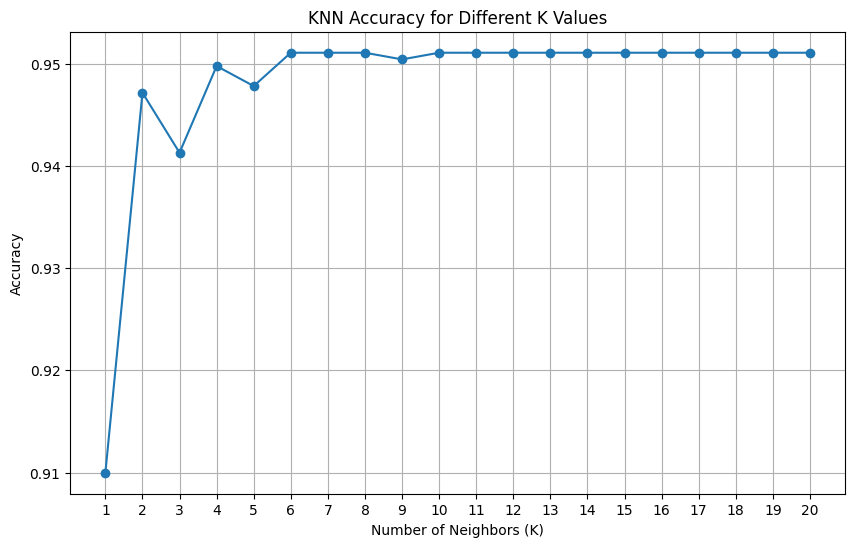

Optimal K: 6
Classification Report for Optimal K:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533

Confusion Matrix for Optimal K:
[[1458    0]
 [  75    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

data = pd.read_csv('/content/gdrive/MyDrive/healthcare-dataset-stroke-data.csv')

data.drop(columns=['id'], inplace=True)
data['bmi'].fillna(data['bmi'].median(), inplace=True)

label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data.drop(columns=['stroke'])
y = data['stroke']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Accuracy for Different K Values')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

# Optimal K evaluation
optimal_k = k_values[np.argmax(accuracies)]
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
y_pred_optimal = knn_optimal.predict(X_test)

# Report for optimal K
print(f"Optimal K: {optimal_k}")
print("Classification Report for Optimal K:")
print(classification_report(y_test, y_pred_optimal))
print("Confusion Matrix for Optimal K:")
print(confusion_matrix(y_test, y_pred_optimal))